<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1xT8bCdUsxjVBp-Y_RUSDcwucnNg7qniK">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/dnguyen2211/DCGAN/blob/master/DL_Seminar_DCGAN_Duy_Nguyen.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

# Hochschule Offenburg - Seminar Deep Learning
## Deep Convolutional Generative Adversarial Network

by Duy Nguyen

This notebook will give you a introduction about the implementation and needed steps for the DCGAN architecture.
For the demonstration this notebook used the MNIST dataset to generate handwriten digits.


________________________________________________________________________________

## Introduction


Deep Convolution Generative Adversarial Network or DCGAN is a advanced solution of GAN. 
The base concept of DCGAN is the same as GAN.



**What is GAN?**

In GAN there are two networks trained simultaneously against each other, the generator learns to create real images, while the discriminator learns to classify real and fake images. The goal is archieved when the discriminator can't no longer distinguish real from fake images.


The following gif shows generated handwritten digits, created by the generator.

![alt text](https://www.tensorflow.org/images/gan/dcgan.gif)

**What is DCGAN?**

As the name indicates, the concept of DCGAN is the same as GAN except for the number of layers. Instead of using a few convolution layers to generate and classify images, DCGAN have multiple covolution layers. With sufficent layers you can call it deep convolution. 

For more information about

DCGAN:

*   https://arxiv.org/pdf/1511.06434.pdf

GAN:

*   https://arxiv.org/pdf/1710.07035.pdf



________________________________________________________________________________

## Import TensorFlow and other libraries

Before we can start with the implementation, we have to install some packages and import libraries.

The code below doing this for us.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import tensorflow as tf

In [0]:
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model


In [0]:
# To generate GIFs
!pip install imageio

!pip install -q pydot
!pip install -q graphviz

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Load and prepare dataset

As already mentioned, we use the MNIST dataset to train the models.

On this point we do not need to load the dataset from Google Drive or other locations. Keras already offers the MNIST and also other datasets.

Link to the datasets: https://www.tensorflow.org/api_docs/python/tf/keras/datasets




_______________________________________________________________________

The following code loads and prepare the dataset for the training.


In [0]:
from keras.datasets.mnist import load_data

(train_images, train_labels), (test_images, test_labels) = load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

## Hyperparameters

The following hyperparameters are used and adjust to train both Networks.

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 100

EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

leakyReLU = 0.2

dropout = 0.3

l_rate = 0.0002
beta = 0.5

## Define and create Generator and Discriminator

In this section the generator and descriminator will be defined. 

Remember, the models parameterisation should only be used for the MNIST dataset. If you want to train the models with other datasets like CIFAR10, CIFAR100 etc. you have to adjust the parameters. It is also advisable to add more layers or replace some layers.



Architecture guidelines for stable Deep Convolutional GANs

*   Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
*   Use batchnorm in both the generator and the discriminator.
*   Remove fully connected hidden layers for deeper architectures.
*   Use ReLU activation in generator for all layers except for the output, which uses Tanh.
*   Use LeakyReLU activation in the discriminator for all layers.

### Generator

The generator uses Transposed layer to produce a image from the previous layer. Start with a Dense layer that takes the seed input and produce a 28x28x1 image for the next layer.

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(leakyReLU))

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(leakyReLU))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(leakyReLU))

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [0]:
#generator model
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

The discriminator is a based CNN classifier, use convolution layers to downsample the input image. At the end the output will be a positiv value for real images and negative value for fake images.

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(leakyReLU))
    model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(leakyReLU))
    model.add(layers.Dropout(dropout))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
#discriminator model
discriminator = make_discriminator_model()
discriminator.summary()

decision = discriminator(generated_image)
print (decision)

## Define loss and optimizer

In this section we will define the loss function and optimizer for both models.

Binary cross entropy is used to compute the loss and the adam optimizer for the optimization.

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**Discriminator loss**

"*This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.*" 

[ https://www.tensorflow.org/tutorials/generative/dcgan ]

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

**Generator loss**

"*The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.*"

[ https://www.tensorflow.org/tutorials/generative/dcgan ] 

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**Optimizer**

The optimizer compute the gradient to udpate the generator and discriminator

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = l_rate, beta_1=beta)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = l_rate, beta_1=beta)

## Training Process

### Generate and save Image


This code generate and save an image.

In [0]:
# Save path for the generated image
image_path = ''

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(image_path + 'image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Generate loss diagram

This code generate a loss diagram of both models, using the losses during the training.

In [0]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = np.array(hist['D_losses'])
    y2 = np.array(hist['G_losses'])

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

### Training

"*The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.*"

[ https://www.tensorflow.org/tutorials/generative/dcgan ]

In [0]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    G_losses = []
    D_losses = []

    start = time.time()

    for image_batch in dataset:
      noise = tf.random.normal([BATCH_SIZE, noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

      D_losses.append(disc_loss)
      G_losses.append(gen_loss)
      


    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

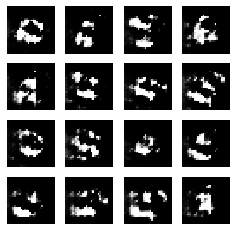

Time for epoch 1 is 1094.9893214702606 sec


In [0]:
#start the training

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train(train_dataset, EPOCHS)

show_train_hist(train_hist, save=True, path='train_hist.png')

### Util

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

The following code create an animated image, using the images during the training.

In [0]:
def generate_gif():
    anim_file = 'dcgan.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
      filenames = glob.glob('image*.png')
      filenames = sorted(filenames)
      last = -1
      for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
          last = frame
        else:
          continue
        image = imageio.imread(filename)
        writer.append_data(image)
      image = imageio.imread(filename)
      writer.append_data(image)

    import IPython
    if IPython.version_info > (6,2,0,''):
      display.Image(filename=anim_file)

## Mount Google Drive

To mount your drive, use the following code



In [0]:
from google.colab import drive
drive.mount('/content/drive')